In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt
import FlickrDataLoader
import torchvision.transforms as transforms
import PIL
%matplotlib inline

In [72]:
img_dir = r'./data/img/Flicker8k_Dataset/'
cap_path = r'./data/label/Flickr8k.lemma.token.txt'
train_txt = r'./data/label/Flickr_8k.trainImages.txt'
val_txt = r'./data/label/Flickr_8k.devImages.txt'
test_txt = r'./data/label/Flickr_8k.testImages.txt'

mytransform = transforms.Compose(
            [
                transforms.Scale((224,224)),
                transforms.ToTensor(),
            ]
        )
flicker8k_val = FlickrDataLoader.Flicker8k(img_dir, cap_path, val_txt, transform=mytransform, train=True)
id2w[2601] = '<start>'
id2w[2602] = '<end>'


In [63]:
class CaptionModel(nn.Module):
    def __init__(self, bsz, feat_dim, n_voc, n_embed, n_hidden):
        super(CaptionModel, self).__init__()
        self.N = bsz
        self.L = feat_dim[0]
        self.C = feat_dim[1]
        self.V = n_voc
        self.M = n_embed
        self.H = n_hidden
        
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax()
        self.bn = nn.BatchNorm1d(self.L)
        
        self.init_h = nn.Linear(self.C, self.H)
        self.init_c = nn.Linear(self.C, self.H)
        
        self.proj = nn.Linear(self.C, self.C, bias=False)
        
        self.att0 = nn.Linear(self.H, self.C, bias=False)
        self.att1 = nn.Linear(self.C, 1)
        
        self.slct = nn.Linear(self.H, 1)
        
        self.encoder = nn.Embedding(self.V, self.M)
        self.rnn = nn.LSTMCell(self.M + self.C, self.H)
        
        self.fc1 = nn.Linear(self.H, self.M)
        self.dropout = nn.Dropout()
        self.fc2 = nn.Linear(self.M, self.V)
        
        self.ctx2out = nn.Linear(self.C, self.M, bias=False)
        
        
    def init_hidden(self, feat):
        feat_mean = torch.mean(feat,dim=1).squeeze(1)
        h0 = self.tanh(self.init_h(feat_mean))
        c0 = self.tanh(self.init_c(feat_mean))
        return (h0, c0)
    
    def lyr_att(self, h, feat, pctx_):
        pctx = self.tanh(self.att0(h).unsqueeze(1) + pctx_)
        out_att = self.att1(pctx.view(-1, self.C)).view(-1, self.L)
        alpha = self.softmax(out_att)
        ctx = torch.sum((alpha.unsqueeze(2) * feat),dim=1).squeeze(1)
        return alpha, ctx, pctx_
    
    def lyr_slct(self, h, ctx):
        beta = self.sigmoid(self.slct(h))
        ctx_ = beta*ctx
        return beta, ctx_
    
    def decoder(self, h, ctx_, x, debug):
        out1 = self.fc1(h) + self.ctx2out(ctx_)
        if debug:
            print out1
            print x
        out2 = self.tanh(out1 + x)
        out2 = self.dropout(out2)
        logit = self.fc2(out2)
        if debug:
            print logit
        return logit
    
    def sample_distr(self, distr, temperature):
        distr = distr*1.0/temperature
        distr = np.exp(distr)
        distr = distr*1.0/np.sum(distr)
        idx = np.random.choice(self.V, 1, p=distr)
        return idx[0]
    
    def forward(self, feat, capt, debug=False, debug2=False):
        
        feat = self.bn(feat)
        h, c = self.init_hidden(feat)
        pctx_ = self.tanh(self.proj(feat))

        seq_len = capt.data.shape[1]
        logit = Variable(torch.zeros((capt.data.shape[0],capt.data.shape[1],self.V))).cuda()
        
        if debug:
            print('output size is {}'.format(logit.data.shape))
        
        alphas = []
        betas = []
        
        for t in range(seq_len):

            x = self.encoder(capt[:,t])
            if debug:
                print('capt size is {}'.format(capt[:,t].data.shape))
                print('x size is {}'.format(x.data.shape))
        
            alpha, ctx, pctx_ = self.lyr_att(h, feat, pctx_)
            if debug:
                print('alpha size is {}'.format(alpha.data.shape))
                print('context size is {}'.format(ctx.data.shape))
            alphas.append(alpha.view(-1,14,14).data.cpu().numpy())
            ctx_ = ctx
#             beta, ctx_ = self.lyr_slct(h, ctx)
#             if debug:
#                 print('beta size is {}'.format(beta.data.shape))
#                 print('context_ size is {}'.format(ctx_.data.shape))
#             betas.append(beta.data.cpu().numpy()[0][0])
            
            input_ = torch.cat((x,ctx_), 1)
            if debug:
                print('input_ size is {}'.format(input_.data.shape))

            h, c = self.rnn(input_, (h,c))

            out = self.decoder(h, ctx_, x, debug2).unsqueeze(1)
            if debug:
                print('output of decode size is {}'.format(out.data.shape))
            
            logit[:,t,:] = out
            
        return logit, alphas,betas
    
    def predict(self, feat, max_len=20, debug=False):
        
        feat = self.bn(feat)
        h, c = self.init_hidden(feat)
        pctx_ = self.tanh(self.proj(feat))

        alphas = []
        betas = []
        
        capt = Variable(torch.LongTensor(np.array([2061]))).cuda()
        if debug:
            print('capt size is {}'.format(capt.data.shape))
        
        count = 0
        preds = []
        
        while True:

            x = self.encoder(capt)
            if debug:
                print('x size is {}'.format(x.data.shape))
        
            alpha, ctx, pctx_ = self.lyr_att(h, feat, pctx_)
            if debug:
                print('alpha size is {}'.format(alpha.data.shape))
                print('context size is {}'.format(ctx.data.shape))
            alphas.append(alpha.view(-1,14,14).data.cpu().numpy())
            ctx_ = ctx
#             beta, ctx_ = self.lyr_slct(h, ctx)
#             if debug:
#                 print('beta size is {}'.format(beta.data.shape))
#                 print('context_ size is {}'.format(ctx_.data.shape))
#             betas.append(beta.data.cpu().numpy()[0][0])
            
            input_ = torch.cat((x,ctx_), 1)
            if debug:
                print('input_ size is {}'.format(input_.data.shape))

            h, c = self.rnn(input_, (h,c))

            out = self.decoder(h, ctx_, x, False).unsqueeze(1)
            if debug:
                print('output of decode size is {}'.format(out.data.shape))
            
            a = self.sample_distr(out.data.cpu()[0][0].numpy(), 0.5)

            capt = Variable(torch.LongTensor(np.array([a]))).cuda()
            
            preds.append(a)
            
            count += 1
            if count==max_len:
                break
    
        return alphas,betas,preds

In [3]:
with open('feat.pkl','r') as f:
    feat = pickle.load(f)
with open('dict.pkl','r') as f:
    w2id, id2w = pickle.load(f)
with open('capt.pkl','r') as f:
    caption = pickle.load(f)

In [64]:
model = CaptionModel(bsz=1, feat_dim=(196, 512), n_voc=2603, n_embed=128, n_hidden=1024).cuda()

In [65]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [66]:
running_loss = []
val_loss = []

In [75]:
for epoch in range(10):
    loss_ = 0
    model.train()
    for i in range(800):
        model.zero_grad()

        c = Variable(torch.FloatTensor(feat[i:i+1])).cuda()
        cap_id = np.random.randint(5,size=1)[0]
        cap = caption[i][cap_id]
        inp = [2601] + cap
        tchr = cap + [2602]
        d = Variable(torch.LongTensor(np.array(inp))).cuda().unsqueeze(0)
        tt = Variable(torch.LongTensor(np.array(tchr))).cuda().unsqueeze(0)


        logt,alphas,betas = model(c, d, False,False)
        loss = criterion(logt.view(-1, model.V), tt.view(-1))
        loss.backward()
        optimizer.step()
        loss_ += loss.data.cpu().numpy()[0]
        if i % 400 == 399:
            running_loss.append(loss_)
            print( '[{} {}] loss: {}'.format(epoch, i+1, loss_*1.0/400))
            loss_ = 0
    loss_ = 0
    for i in range(200):
        model.eval()

        c = Variable(torch.FloatTensor(feat[i+800:i+801]), volatile=True).cuda()
        cap_id = np.random.randint(5,size=1)[0]
        cap = caption[i+800][cap_id]
        inp = [2601] + cap
        tchr = cap + [2602]
        d = Variable(torch.LongTensor(np.array(inp))).cuda().unsqueeze(0)
        tt = Variable(torch.LongTensor(np.array(tchr))).cuda().unsqueeze(0)

        logt,alphas,betas = model(c, d, False,False)
        loss = criterion(logt.view(-1, model.V), tt.view(-1))
        loss_ += loss.data.cpu().numpy()[0]
    print( 'Epoch {}: validation loss: {}'.format(epoch, loss_*1.0/200))
    val_loss.append(loss_*1.0/200)

[0 400] loss: 3.56473731965
[0 800] loss: 3.41028110981
Epoch 0: validation loss: 3.58402507007
[1 400] loss: 3.43451595291
[1 800] loss: 3.26551176026
Epoch 1: validation loss: 3.62231947303
[2 400] loss: 3.25346164674
[2 800] loss: 3.23312354118
Epoch 2: validation loss: 3.53018715501
[3 400] loss: 3.15920848265
[3 800] loss: 3.09677834183
Epoch 3: validation loss: 3.56806898892
[4 400] loss: 3.06083862409
[4 800] loss: 3.07541433409
Epoch 4: validation loss: 3.51113925874
[5 400] loss: 3.00764449105
[5 800] loss: 2.93652991146
Epoch 5: validation loss: 3.50515021503
[6 400] loss: 2.85710558474
[6 800] loss: 2.86053011551
Epoch 6: validation loss: 3.49314252675
[7 400] loss: 2.79601396456
[7 800] loss: 2.83236043736
Epoch 7: validation loss: 3.43202574193
[8 400] loss: 2.70161749825
[8 800] loss: 2.70137621716
Epoch 8: validation loss: 3.52526843071
[9 400] loss: 2.67662430391
[9 800] loss: 2.6151460892
Epoch 9: validation loss: 3.40513035119


In [200]:
# torch.save(model.state_dict(),'model_a.pth')

In [195]:
model = CaptionModel(bsz=1, feat_dim=(196, 512), n_voc=2603, n_embed=128, n_hidden=1024).cuda()
model.load_state_dict(torch.load('model_a.pth'))

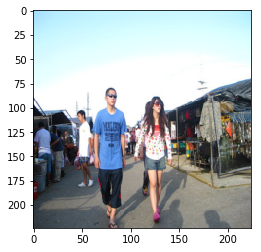

In [319]:
i = 998
image,cpat = flicker8k_val[i]
plt.imshow(image.numpy().transpose(1,2,0))

In [321]:
model.eval()
c = Variable(torch.FloatTensor(feat[i:i+1]), volatile=True).cuda()
cap_id = np.random.randint(5,size=1)[0]
cap = caption[i][cap_id]
inp = [2601] + cap
tchr = cap + [2602]
d = Variable(torch.LongTensor(np.array(inp))).cuda().unsqueeze(0)
tt = Variable(torch.LongTensor(np.array(tchr))).cuda().unsqueeze(0)

alphas,betas,preds = model.predict(c, 10, False)

text_ = ''
for v in preds:
    if v==2601:
        text_ += '<start> '
    elif v==2602:
        text_ += '<end> '
    else:
        text_ += id2w[v]+' '
print text_

a woman be walk through a park . <end> . 


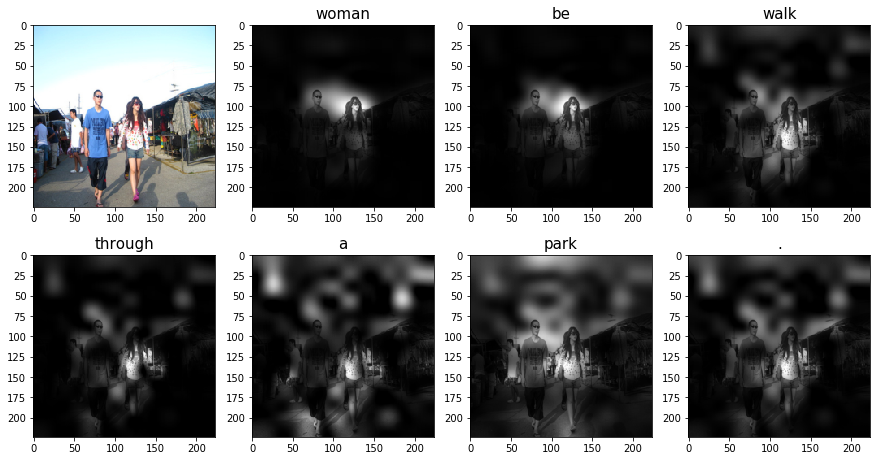

In [322]:
img_ = np.uint8(image.numpy().transpose(1,2,0)*255)
img = PIL.Image.fromarray(img_).convert('L')

plt.figure(figsize=(15,12))
plt.subplot(3,4,1)
plt.imshow(img_)
for iii in range(7):
    max_ = np.max(alphas[iii+1][0])
    att = alphas[iii+1][0]/max_ + 0.0/255
    att = PIL.Image.fromarray(np.uint8(att*255))

    att = att.resize((224,224), PIL.Image.ANTIALIAS)
    
    plt.subplot(3,4,iii+2)
    plt.imshow(np.asarray(att).astype(float)*np.asarray(img).astype(float), cmap='gray')
    plt.title( id2w[preds[iii+1]], fontsize=15)

In [74]:
# plt.plot(np.array(running_loss)/400)
# plt.plot(np.array(val_loss))

In [115]:
model.eval()
i = 801
c = Variable(torch.FloatTensor(feat[i:i+1]), volatile=True).cuda()
cap_id = np.random.randint(5,size=1)[0]
cap = caption[i][cap_id]
inp = [2601] + cap
tchr = cap + [2602]
d = Variable(torch.LongTensor(np.array(inp))).cuda().unsqueeze(0)
tt = Variable(torch.LongTensor(np.array(tchr))).cuda().unsqueeze(0)

logt,alphas,betas = model(c, d, False,False)

In [116]:
values,indices = torch.max(logt, dim=2)
text_pred = ''
for v in indices.data.cpu().numpy()[0]:
    if v==2601:
        text_pred += '<start> '
    elif v==2602:
        text_pred += '<end> '
    else:
        text_pred += id2w[v]+' '
print text_pred

a young play black dress through a trampoline . <end> 


In [117]:
text_targ = ''
for v in tt.data.cpu().numpy()[0]:
    if v==2601:
        text_targ += '<start> '
    elif v==2602:
        text_targ += '<end> '
    else:
        text_targ += id2w[v]+' '
print text_targ

two child wear denim walk on a runway . <end> 


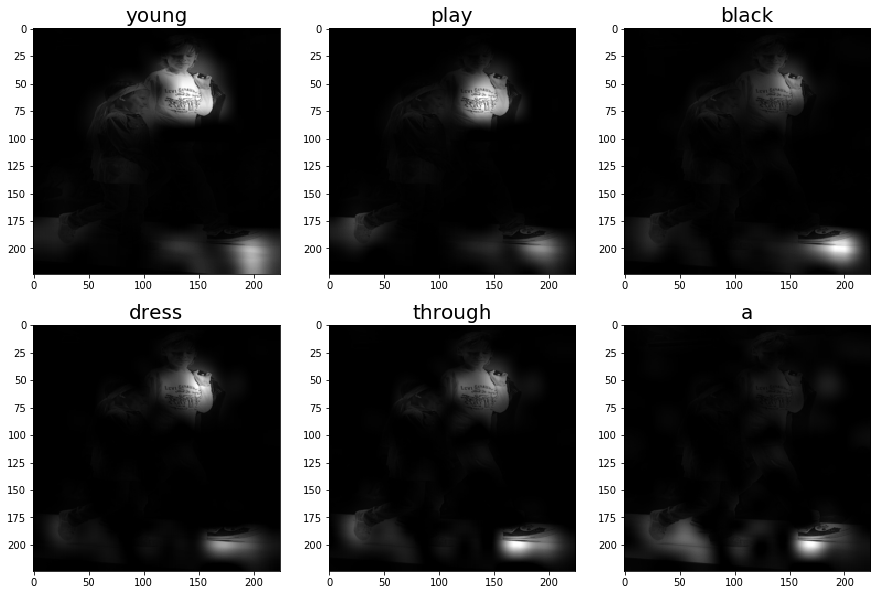

In [118]:
img_ = np.uint8(image.numpy().transpose(1,2,0)*255)
img = PIL.Image.fromarray(img_).convert('L')

plt.figure(figsize=(15,10))
for iii in range(6):
    max_ = np.max(alphas[iii+1][0])
    att = alphas[iii+1][0]/max_ + 0.0/255
    att = PIL.Image.fromarray(np.uint8(att*255))

    att = att.resize((224,224), PIL.Image.ANTIALIAS)
    
    plt.subplot(2,3,iii+1)
    plt.imshow(np.asarray(att).astype(float)*np.asarray(img).astype(float), cmap='gray')
    plt.title( id2w[indices.data.cpu().numpy()[0][iii+1]], fontsize=20)